# Tutorial 6: Population Level Modeling (with PopNet)

In this tutorial we will focus on modeling of populations and population firing rates. This is done with the PopNet simulator application of bmtk which uses [DiPDE](https://github.com/AllenInstitute/dipde) engine as a backend. We will first build our networks using the bmtk NetworkBuilder and save them into the SONATA data format. Then we will show how to simulate the firing rates over a given time-source.

Requirements:
* BMTK
* DiPDE

## 1. Building the network


#### Converting existing networks
Like BioNet for biophysically detailed modeling, and PointNet with point-based networks, PopNet stores networks in the SONATA data format. PopNet supports simulating networks of individual cells at the population level. First thing you have to do is modify the node-types and edge-types of an existing network to use Population level models (rather than models of individual cells. 

<div class="alert alert-warning">
**WARNING** - Converting a network of individual nodes into population of nodes is good for a quick and naive simulation, but for faster and more reliable results it's best to build a network from scratch (next section).
</div>

Here is the node-types csv file of a network set to work with BioNet 

In [1]:
import pandas as pd

pd.read_csv('sources/chapter06/converted_network/V1_node_types_bionet.csv', sep=' ')

,node_type_id,ei,morphology_file,model_processing,pop_name,location,model_template,model_type,dynamics_params
0,100,e,Scnn1a.swc,aibs_perisomatic,Scnn1a,L4,ctdb:Biophys1.hoc,biophysical,472363762_fit.json
1,101,i,Pvalb.swc,aibs_perisomatic,PV,L4,ctdb:Biophys1.hoc,biophysical,472912177_fit.json
2,102,e,NaN,NaN,LIF_exc,VisL4,nrn:IntFire1,point_process,IntFire1_exc_1.json
3,103,i,NaN,NaN,LIF_inh,VisL4,nrn:IntFire1,point_process,IntFire1_inh_1.json


vs the equivelent form for PopNet

In [2]:
pd.read_csv('sources/chapter06/converted_network/V1_node_types_popnet.csv', sep=' ')

,node_type_id,ei,morphology_file,model_processing,pop_name,location,model_template,model_type,dynamics_params
0,100,e,NaN,NaN,Scnn1a,L4,dipde:Internal,population,472363762_pop.json
1,101,i,NaN,NaN,PV,L4,dipde:Internal,population,472912177_pop.json
2,102,e,NaN,NaN,LIF_exc,VisL4,dipde:Internal,population,IntFire1_exc_pop.json
3,103,i,NaN,NaN,LIF_inh,VisL4,dipde:Internal,population,IntFire1_inh_pop.json


Some things to note:
* **model_type** is now a population for all nodes, rather than individual biophysical/point types
* We have set **model_template** to dipde:Internal which will tell the simulator to use special DiPDE model types
* We are using new **dynamic_params** files with parameters that have been adjusted to appropiate range for DiPDE models.
* **morophology_file** and **model_processing**, which were used to set and processes individual cell morphologies, is no longer applicable.

We must make similar adjustments to our edge_types.csv files. And finally when we run the simulation we must tell PopNet to cluster nodes together using the **group_by** property

```python
network = popnet.PopNetwork.from_config(configure, group_by='node_type_id')
```


#### Building a network

We will create a network of two populations, one population of excitatory cells and another of inhibitory cells. Then we will save the network into SONATA formated data files.

The first step is to use the NetworkBuilder to instantiate a new network with two populations:

In [3]:
from bmtk.builder import NetworkBuilder


net = NetworkBuilder('V1')
net.add_nodes(
    pop_name='excitatory',  # name of specific population optional
    ei='e',  # Optional
    location='VisL4',  # Optional
    model_type='population',  # Required, indicates what types of cells are being model
    model_template='dipde:Internal',  # Required, instructs what DiPDE objects will be created
    dynamics_params='exc_model.json'  # Required, contains parameters used by DiPDE during initialization of object
)

net.add_nodes(
    pop_name='inhibitory',
    ei='i',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='inh_model.json'
)

Next we will create connections between the two populations:

In [4]:
net.add_edges(
    source={'ei': 'e'}, target={'ei': 'i'},
    syn_weight=0.005,
    nsyns=20,
    delay=0.002,
    dynamics_params='ExcToInh.json'
)

net.add_edges(
    source={'ei': 'i'}, target={'ei': 'e'},
    syn_weight=-0.002,
    nsyns=10,
    delay=0.002,
    dynamics_params='InhToExc.json'
)

and finally we must build and save the network

In [5]:
net.build()
net.save(output_dir='sim_ch06/network')

##### External Nodes

The *dipde:Internal* nodes we created don't carry intrinsic firing rates, and instead we will use External Populations to drive the network activity. To do this we will create a separate network of 'virtual' populations, or alternativly use model_type=dipde:External, that connect to our excitatory population.  

Note: we could add 'virtual' populations directly to our V1 network. However creating them as a separate network provides a great advantage if/when we want to replace our external connections with a different model (Or if we want to remove the reccurrent connections and simulation with only feed-foward activity).

In [6]:
input_net = NetworkBuilder('LGN')
input_net.add_nodes(
    pop_name='tON',
    ei='e',
    model_type='virtual'
)

input_net.add_edges(
    target=net.nodes(ei='e'),
    syn_weight=0.0025,
    nsyns=10,
    delay=0.002,
    dynamics_params='input_ExcToExc.json'
)

input_net.build()
input_net.save(output_dir='sim_ch06/network')

## 2. Setting up the PopNet environment

Before running the simulation we need to set up our simulation environment, inlcuding setting up run-scripts, configuration parameters, and placing our parameter files in their appropiate location. The easiest way to do this is through the command-line:

```bash
$ python -m bmtk.utils.sim_setup -n network --tstop 1500.0 popnet sim_ch06/
```

Which creates initial files to run a 1500 ms simulation using the network files found in our ./network directory.

#### Inputs

We next need to set the firing rates of the External Population. There are multiple ways to set this value which will be discussed later. The best way is to set the firing rates using a input-rates file for each External Population, we can fetch an existing one using the command:

```bash
 $ cd sim_ch06
 $ wget https://github.com/AllenInstitute/bmtk/raw/develop/examples/pop_2pops/inputs/external_rates.csv -O lgn_rates.csv

```

Then we must open the simulation_config.json file with a text editor and add the lgn_rates.csv file as a part of our inputs:

```json
{
  "inputs": {
    "LGN_pop_rates": {
      "input_type": "csv",
      "module": "pop_rates",
      "rates": "${BASE_DIR}/lgn_rates.csv",
      "node_set": "LGN"
    }
  }
}
```

## 3. Running the simulation

The call to sim_setup created a file run_pointnet.py which we can run directly in a command line:
```bash
$ python run_popnet.py config.json
```

Or we can run it directly using the following python code:

In [7]:
from bmtk.simulator import popnet

configure = popnet.config.from_json('sim_ch06/config.json')
configure.build_env()
network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

2022-08-09 16:50:15,019 [WARNING] Directory /home/ping/bmtk_change/bmtk/docs/tutorial/sim_ch06/output already exists.
2022-08-09 16:50:15,020 [INFO] Created log file
2022-08-09 16:50:15,054 [INFO] Building cells.
2022-08-09 16:50:15,055 [INFO] Building recurrent connections
2022-08-09 16:50:15,059 [INFO] Build virtual cell stimulations for LGN_pop_rates
2022-08-09 16:50:15,078 [INFO] Network created.
2022-08-09 16:50:15,080 [INFO] Running simulation.
2022-08-09 16:50:18,766 [INFO] Finished simulation.


## 4. Analyzing results

As specified in the "output" section of simulation_config.json, the results will be written to ouput/spike_rates.csv. The BMTK analyzer includes code for ploting and analyzing the firing rates of our network:

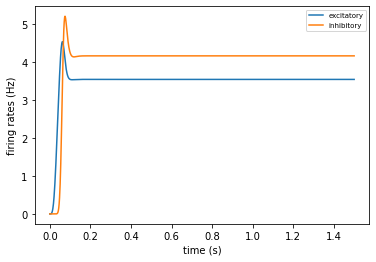

In [8]:
from bmtk.analyzer.firing_rates import plot_rates_popnet

plot_rates_popnet('sim_ch06/network/V1_node_types.csv', 'sim_ch06/output/firing_rates.csv', model_keys='pop_name')